In [74]:
#analysis
import glob
import os, sys
current_dir = os.path.dirname(os.path.realpath('__file__'))
os.path.abspath(os.getcwd())
sys.path.append("C:\\Users\\abel_\\Documents\\Rotations\\CIT")
sys.path.append('C:\\Users\\abel_\\Documents\\Rotations\\CIT\cit_for_computation')

import torch
import torch.nn as nn
import torch.optim as optim
# import torch.nn.init as weight_init

import scipy
from scipy.optimize import minimize
from functools import partial
import numpy as np
import numpy.ma as ma
import pickle
import re
import time
from tqdm.notebook import tqdm
from IPython.display import display, Math

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
import matplotlib.cm as cmx
import sklearn
import sklearn.decomposition

def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

from utils import *
from analysis_functions import *
current_dir = 'C:\\Users\\abel_\\Documents\\Rotations\\CIT\cit_for_computation'

In [76]:
#load model
current_dir = "C:\\Users\\abel_\\Documents\\Rotations\\CIT\\cit_for_computation"
exp_extension = "\\experiments\\poisson_clicks\\cued_curr_4\\"
exp_extension = "\\experiments\\poisson_clicks\\"

exp_list = glob.glob(current_dir + exp_extension + "\\exp*19")
# exp_list = sorted(exp_list, key = lambda x: int(x.split("Nrec")[-1].split("_")[-1]))
exp_path = exp_list[0]
exp_path

'C:\\Users\\abel_\\Documents\\Rotations\\CIT\\cit_for_computation\\experiments\\poisson_clicks\\exp_idx2_1665049319'

In [77]:
# exp_path = current_dir + 'exp_single_sumofrates1000.0_cosineannealing_30_accuracygoal0.95_maxepochs200_Nrec1_1656020558exp_single_sumofrates1000.0_cosineannealing_30_accuracygoal0.95_maxepochs200_Nrec1_1656020558' #
# exp_path = exp_list[-last_i]
idx = exp_path[-10:]

with open(exp_path + '\\training_kwargs.pickle', 'rb') as handle:
    training_kwargs = pickle.load(handle)
    
training_kwargs['exp_path'] = exp_path
training_kwargs['training_weights_path'] = exp_path+'/training/'
training_kwargs['figures_path'] = exp_path + '//figures/'

idx = int(re.search(r'\d+', exp_path).group())

rnn_model = RNNModel(training_kwargs['N_in'], training_kwargs['N_out'], training_kwargs['N_rec'], n_layers=1, transform_function='relu').to(device)

# file = train_params['save_weights_path']+'\\weights%s.pth'%network_params['idx']
rnn_model = load_model(rnn_model, training_kwargs)
rnn_model.eval();

In [78]:
#load non-final model

weight_list = glob.glob(training_kwargs['training_weights_path']+'\\*')
# weight_list.remove(training_kwargs['training_weights_path']+"\weights_epochstart_5.pth") #better way to remove start? Or just store it differently...

for file in weight_list:
    lastbit = file.split("weights",1)[1].split("_",1)[-1]
    epoch = lastbit.split("epoch",1)[1].split("_",1)[0]
    # print(epoch)

weight_list = sorted(weight_list, key = lambda x: int(x.split("epoch")[-1].split(".")[-2]))
weight_list = sorted(weight_list, key = lambda x: (1/float(x.split("coh")[-1].split("_")[-3]), int(x.split("epoch")[-1].split(".")[-2])))

weight_path = weight_list[-111]

rnn_model.load_state_dict(torch.load(weight_path, map_location=torch.device(device)))

<All keys matched successfully>

Losses

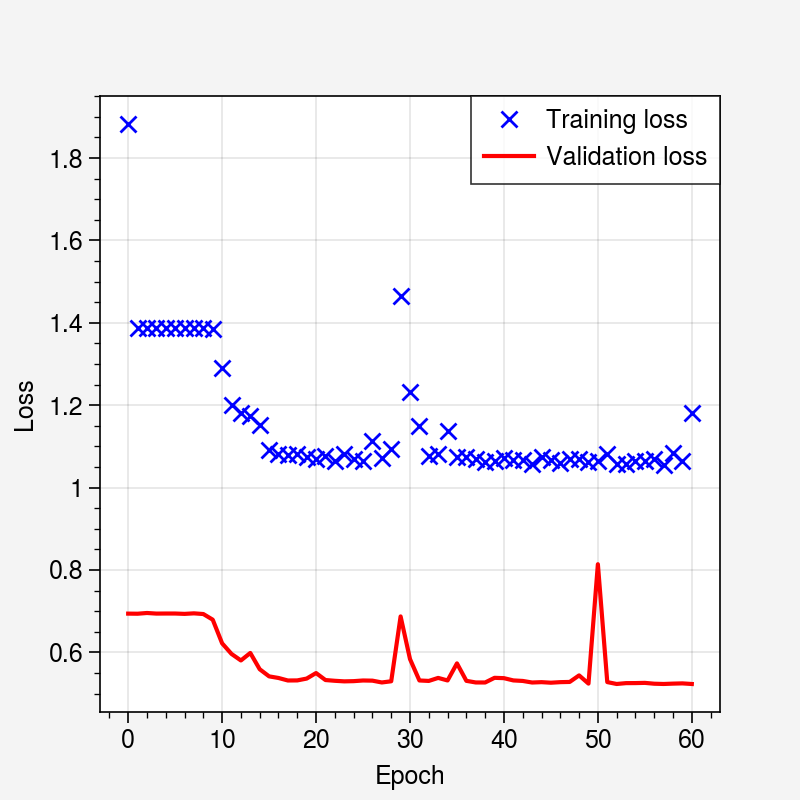

In [79]:
with open(training_kwargs['exp_path'] + '/learning_info.pickle', 'rb') as handle:
    learning_info = pickle.load(handle)
epoch_counter = 0
losses = learning_info['training_loss']
plt.plot(range(epoch_counter, epoch_counter+len(losses)), losses, 'bx', label="Training loss")
val_losses = learning_info['validation_loss']
plt.plot(range(epoch_counter, epoch_counter+len(losses)), val_losses, 'r', label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
# plt.ylim([0, max([losses[0], val_losses[0]])])
# plt.ylim([0, 1])
plt.legend(['Training loss', 'Validation loss'])
plt.savefig(training_kwargs['figures_path'] + '/losses_opt'+training_kwargs['optimizer']+'lr'+str(training_kwargs['learning_rate'])+'.pdf')

 <font size="10">Weights  <font>

In [80]:
rnn_model.state_dict().keys()
# row_labels = ['Z', 'Y', 'X', 'W']
# column_labels = []
# df = pandas.DataFrame(x)
import pandas
weights_dict = {key: pandas.DataFrame(rnn_model.state_dict()[key]) for key in rnn_model.state_dict().keys()}

C:\Users\abel_\AppData\Local\Temp\ipykernel_17572\1151607978.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(im, ax=ax, location='right', anchor=(0, 0.), shrink=0.99)


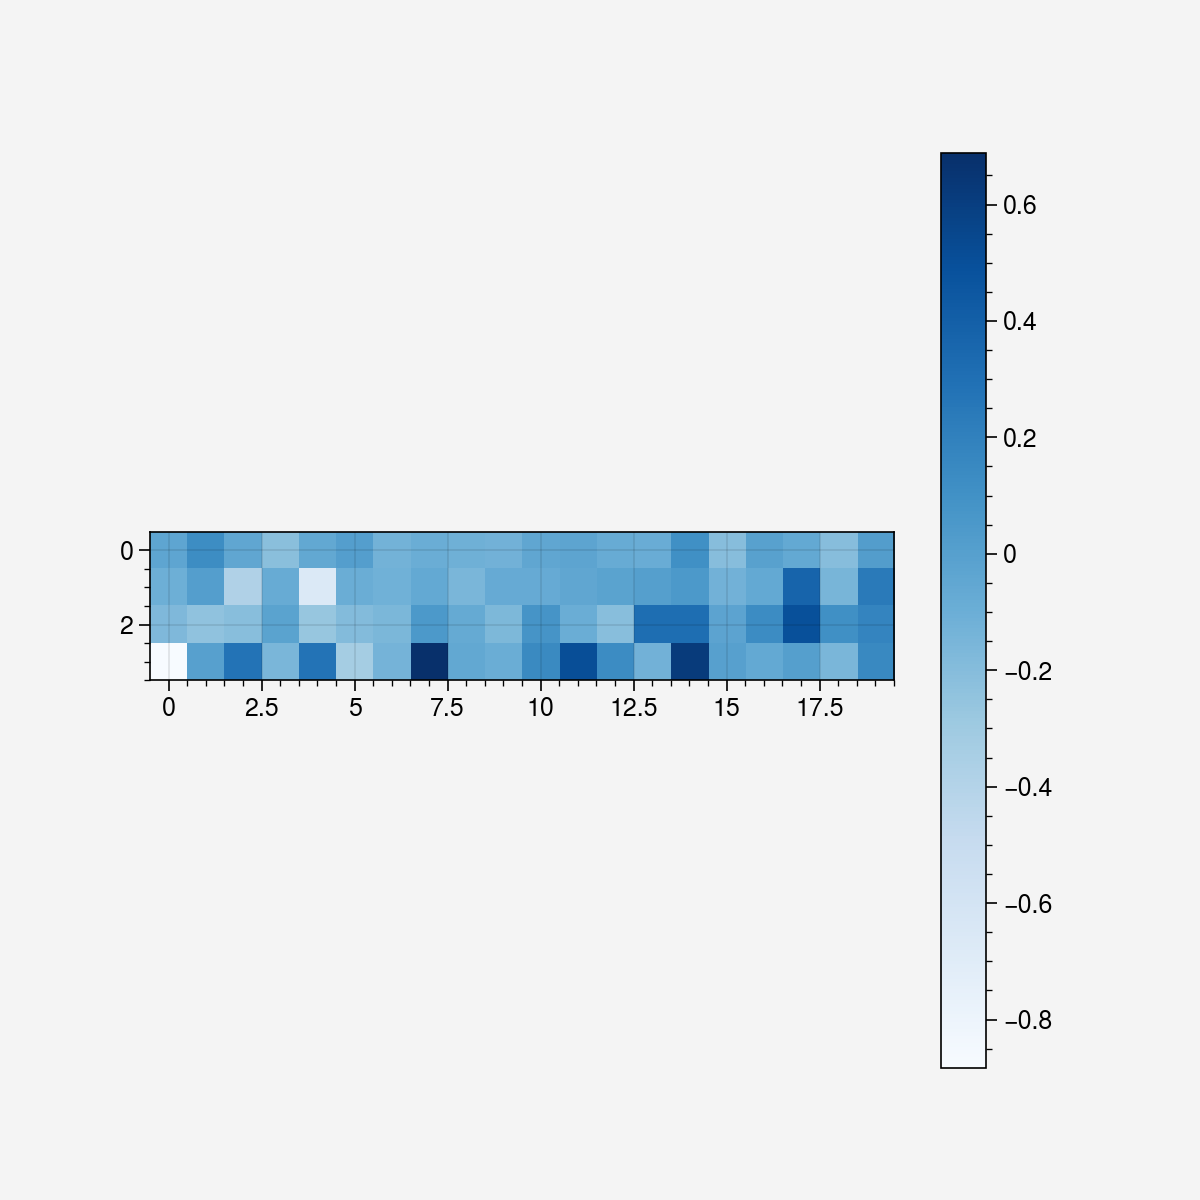

In [81]:
#input weights
W_ih = weights_dict['rnn.weight_ih_l0'] 

fig, (ax) = plt.subplots(figsize=(6, 6), ncols=1)
im = ax.imshow(W_ih.T, cmap='Blues', interpolation='none')
fig.colorbar(im, ax=ax, location='right', anchor=(0, 0.), shrink=0.99)

In [82]:
print("W_in=")
print(W_ih)
b_in = weights_dict['rnn.bias_ih_l0']
print("\n b_in:")
print(b_in)

W_in=
           0         1         2         3
0  -0.037915 -0.107878 -0.172422 -0.883280
1   0.125888  0.010744 -0.242780 -0.002963
2  -0.047494 -0.382565 -0.208864  0.278941
3  -0.217744 -0.082587 -0.020893 -0.158343
4  -0.058476 -0.666882 -0.265792  0.277187
5   0.008878 -0.095832 -0.190863 -0.325098
6  -0.128327 -0.119410 -0.164692 -0.134854
7  -0.096746 -0.063609  0.045536  0.688115
8  -0.115163 -0.158126 -0.067663 -0.057903
9  -0.127753 -0.077888 -0.165185 -0.093492
10 -0.042882 -0.074255  0.078492  0.144298
11 -0.030249 -0.046844 -0.094097  0.504447
12 -0.084339 -0.018543 -0.208189  0.134519
13 -0.088790  0.005355  0.312204 -0.122557
14  0.110154  0.046380  0.311314  0.617896
15 -0.206488 -0.123373 -0.025551 -0.000254
16 -0.009241 -0.062094  0.134265 -0.061489
17 -0.066690  0.370542  0.494697  0.002219
18 -0.202467 -0.150830  0.109664 -0.155754
19  0.015006  0.239509  0.177368  0.153392

 b_in:
           0
0  -0.010994
1   0.125010
2  -0.076980
3  -0.018240
4   0.056257
5   0

C:\Users\abel_\AppData\Local\Temp\ipykernel_17572\485890295.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(im, ax=ax, location='right', anchor=(0, 0.5), shrink=0.8);


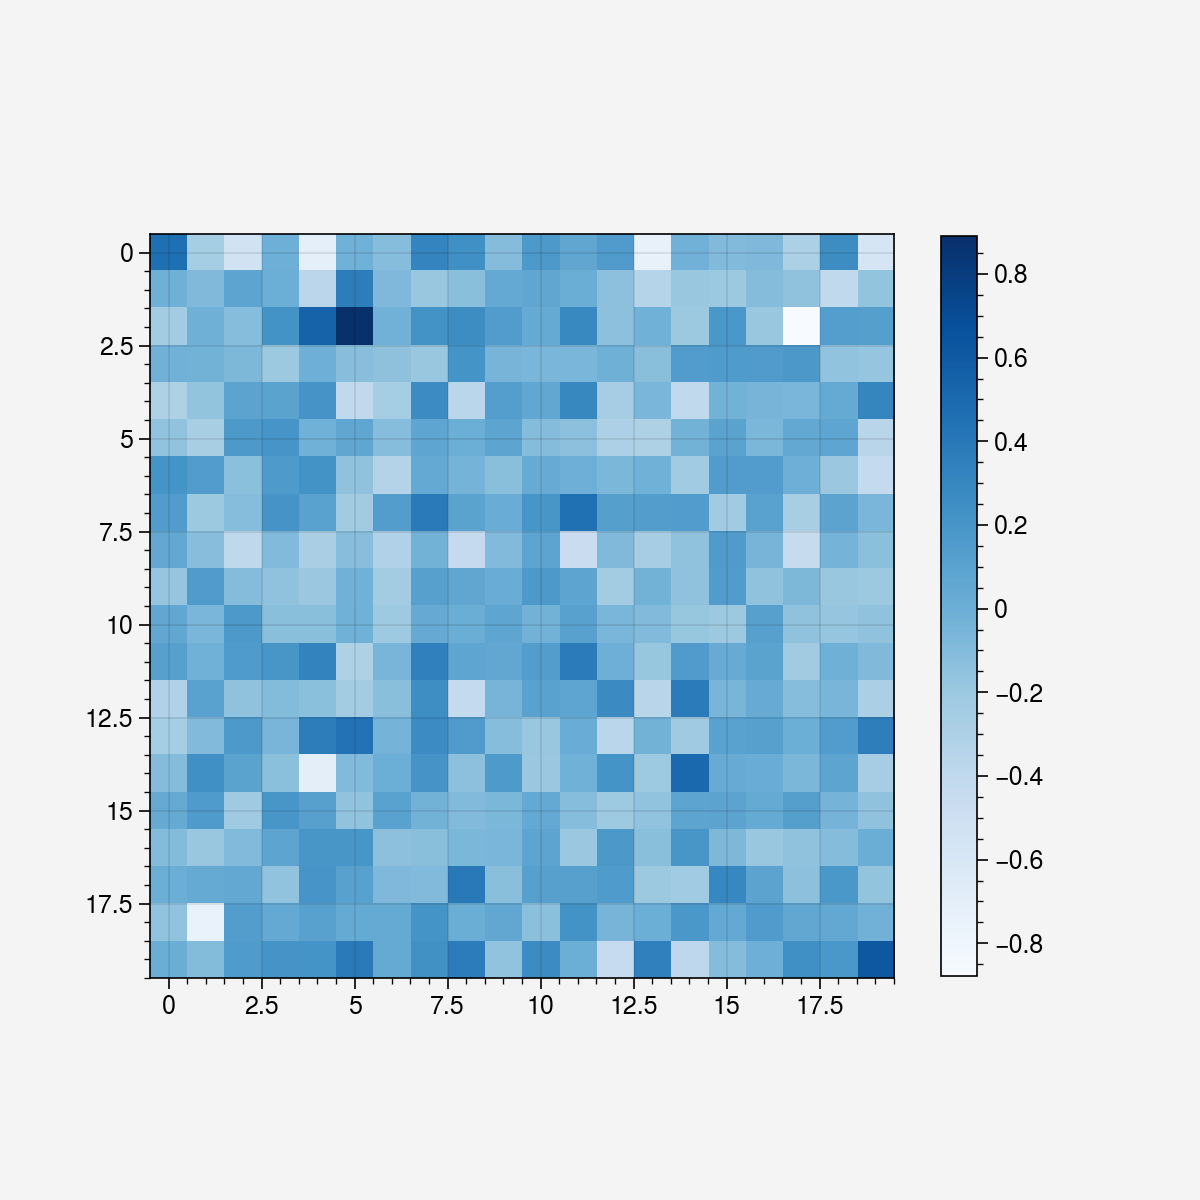

In [83]:
#recurrence weights
W_hh = rnn_model.state_dict()['rnn.weight_hh_l0'] #['rnn.weight_ih_l0']

fig, (ax) = plt.subplots(figsize=(6, 6), ncols=1)
im = ax.imshow(W_hh, cmap='Blues', interpolation='none')
fig.colorbar(im, ax=ax, location='right', anchor=(0, 0.5), shrink=0.8);

In [84]:
print("W_h=")
print(W_hh)
b_h = weights_dict['rnn.bias_hh_l0']
print("\n b_h:")
print(b_h)

W_h=
tensor([[ 4.5798e-01, -2.4920e-01, -5.3772e-01, -2.4098e-03, -7.2481e-01,
         -1.8650e-02, -1.1567e-01,  3.1247e-01,  2.3760e-01, -1.0611e-01,
          1.6889e-01,  6.7085e-02,  1.4914e-01, -7.5087e-01, -2.6715e-02,
         -9.1830e-02, -8.1297e-02, -2.9199e-01,  2.5998e-01, -5.7501e-01],
        [-1.0972e-02, -8.7173e-02,  7.9573e-02,  5.4935e-03, -3.7377e-01,
          3.6281e-01, -8.1599e-02, -1.9422e-01, -1.2996e-01,  4.6920e-02,
          6.6036e-02,  1.1500e-02, -1.4022e-01, -3.4599e-01, -1.9384e-01,
         -2.1131e-01, -1.0905e-01, -1.5639e-01, -4.1017e-01, -1.6714e-01],
        [-2.4525e-01, -8.7640e-03, -1.1581e-01,  2.1869e-01,  5.4454e-01,
          8.8968e-01, -2.4645e-02,  2.1685e-01,  2.5861e-01,  1.3894e-01,
          3.5463e-02,  2.8830e-01, -1.4430e-01, -2.1048e-02, -2.0912e-01,
          1.8456e-01, -1.9498e-01, -8.7722e-01,  1.2778e-01,  1.1944e-01],
        [-2.6615e-02, -3.2213e-02, -7.6119e-02, -2.1028e-01, -1.8312e-03,
         -1.1892e-01, -1.5238e

C:\Users\abel_\AppData\Local\Temp\ipykernel_17572\2921442239.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(im, ax=ax, location='right', anchor=(0, 0.), shrink=0.99)


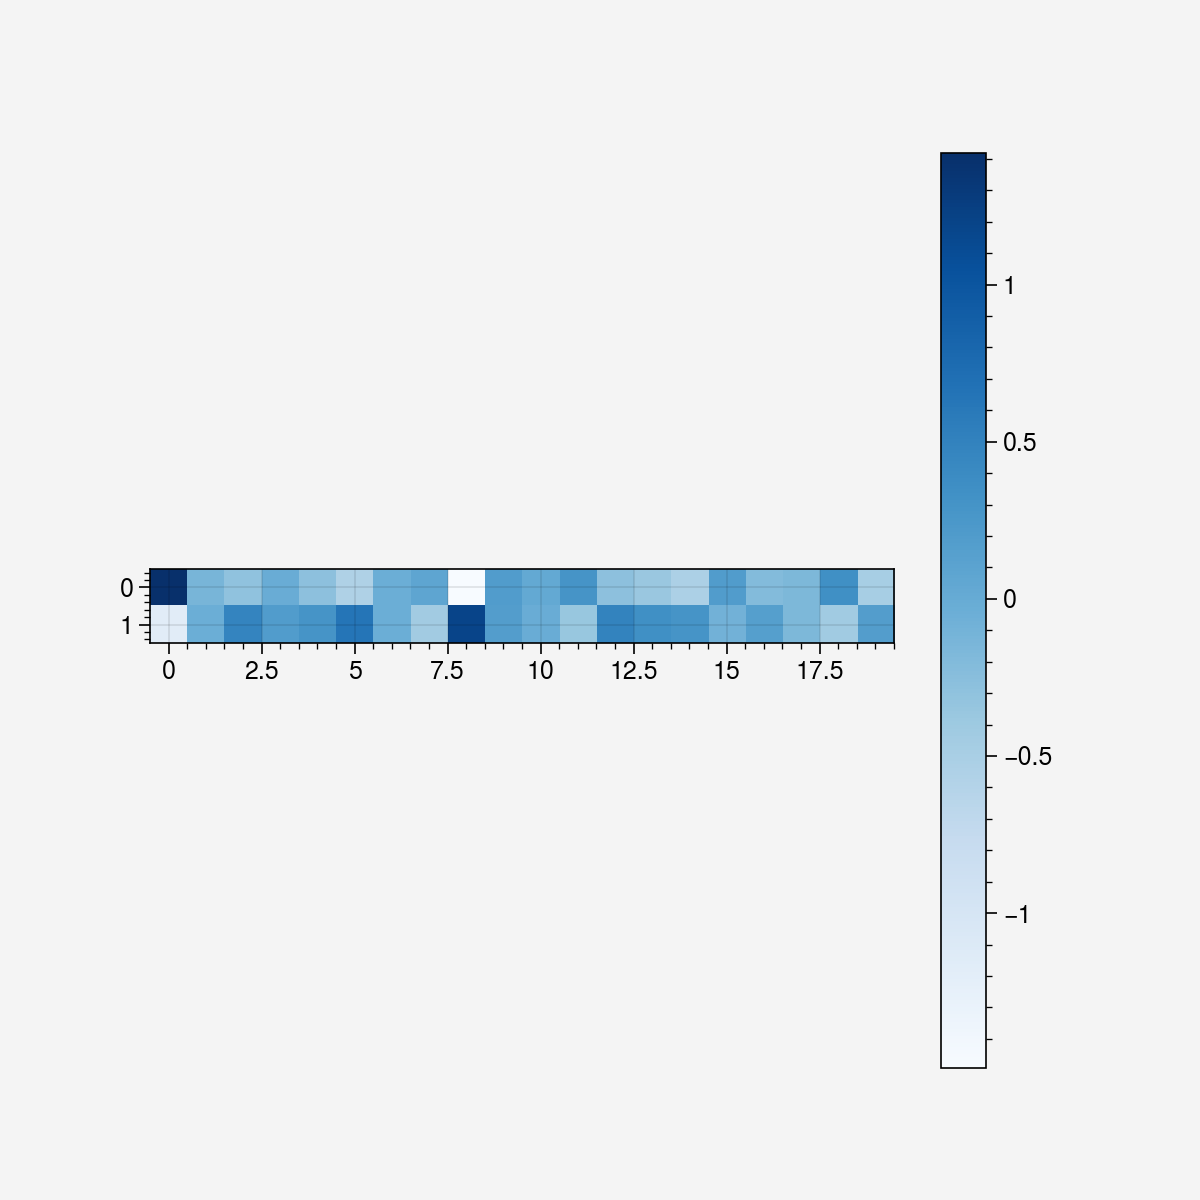

In [85]:
#output weights
W_ho = rnn_model.state_dict()['fc.weight'] 
fig, (ax) = plt.subplots(figsize=(6, 6), ncols=1)
im = ax.imshow(W_ho, cmap='Blues', interpolation='none')
fig.colorbar(im, ax=ax, location='right', anchor=(0, 0.), shrink=0.99)

In [86]:
print("W_out=")
print(W_ho)
print("\n b_out:")
print(weights_dict['fc.bias'])

W_out=
tensor([[ 1.4176, -0.1381, -0.3038, -0.0159, -0.2863, -0.5541, -0.0382,  0.0757,
         -1.4927,  0.1839,  0.0302,  0.2850, -0.2845, -0.3673, -0.5297,  0.1820,
         -0.2128, -0.1725,  0.3459, -0.4896],
        [-1.1646, -0.0388,  0.4740,  0.1848,  0.2910,  0.6372, -0.0454, -0.4439,
          1.1804,  0.1765, -0.0231, -0.3570,  0.4741,  0.3475,  0.2910, -0.0883,
          0.1476, -0.1635, -0.4262,  0.1711]])

 b_out:
          0
0  0.471489
1 -0.344942


# Analytical

In [87]:
b = b_in + b_h
b = b[0].to_numpy()

try:
    W_hh = W_hh.numpy()
    b = b[0].to_numpy()
    W_ih = W_ih.to_numpy()
except:
    0
print("Effective b=", b)

Effective b= [ 0.03971687  0.14365456 -0.08588133 -0.22618885  0.0161527   0.3631634
 -0.10107949 -0.04889719  0.13089049 -0.07847929 -0.13149624 -0.10735544
  0.03820999 -0.01355784  0.1255577  -0.18672952 -0.38878965  0.01745225
 -0.11441804 -0.03120597]


In [88]:
def lu_step(x, W, b):
    return x*W+b

def relu_step(x, W, b):
    res = np.array(np.dot(W,x)+b)
    res[res < 0] = 0
    return res
 
def relu_step_input(x, W, b, W_ih, I):
    res = np.array(np.dot(W,x) + b + np.dot(W_ih, I))
    res[res < 0] = 0
    return res

#intersection with x-axis:
print(r"$x_0$: ", -b/W_hh.diagonal())

#intersection with diagonal line:
x_s = b/(1-W_hh.diagonal())
print(r"$x$: ", x_s)

$x_0$:  [-0.08672248  1.647917   -0.74154806 -1.0756809  -0.07864617 -5.40478
 -0.2992297   0.12762466  0.30507436  4.159897   -4.620894    0.28817192
 -0.14096218 -0.41971096 -0.24971831  2.257878   -2.047719    0.12452124
  2.2162201   0.05065187]
$x$:  [ 0.07327519  0.13213582 -0.07696745 -0.18689045  0.0203277   0.3893232
 -0.07555657 -0.07926697  0.09159301 -0.07998832 -0.12785779 -0.17109513
  0.05241897 -0.01313359  0.25252825 -0.20356458 -0.32675114  0.01530691
 -0.12064674 -0.08128399]


In [89]:
xmin, xmax = -10, 20
x = np.linspace(xmin, xmax, 100)

xlu =  np.linspace(-b/W_hh.diagonal(), xmax, 100)
xslope = xlu*W_hh.diagonal() + b
xflat = np.linspace(xmin, -b/W_hh.diagonal(), 100)
yflat = np.zeros(100)

xslope.shape

(100, 20)

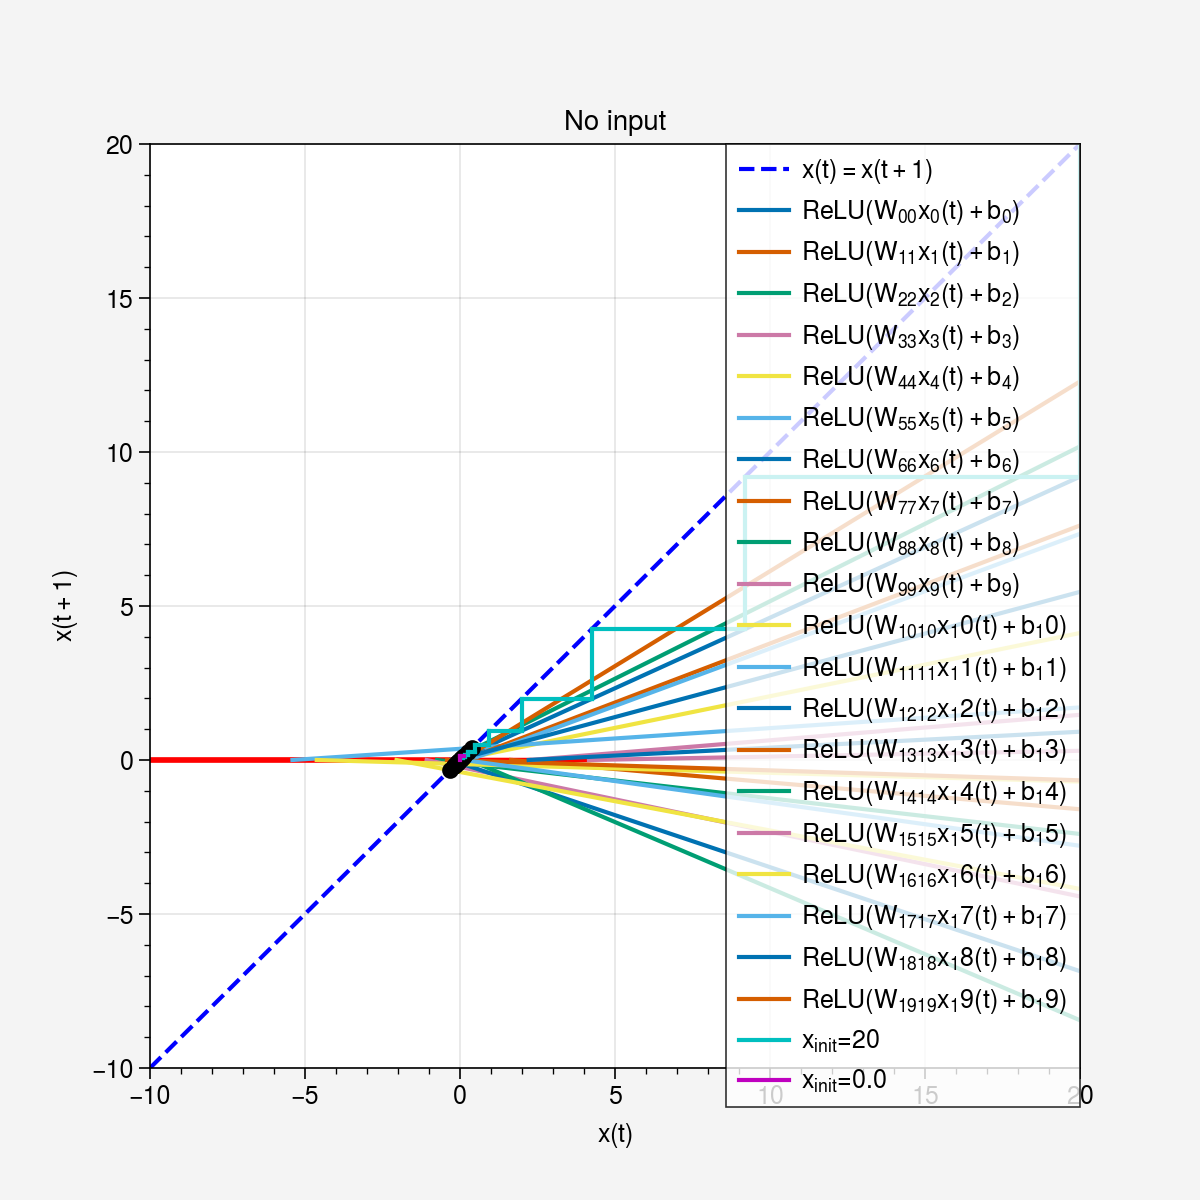

In [90]:
#NOTE: should not extend beyond x(t+1)<0
plt.figure(figsize=(6,6))
plt.plot(x, x, '--b', label="$x(t)=x(t+1)$")

plt.plot(xflat, yflat, 'r')
# plt.plot(xlu[:,0], xslope[:,0], 'r', label="ReLU($W_{11}x_1(t)+b_1$)")
# plt.plot(xlu[:,1], xslope[:,1], 'orange', label="ReLU($W_{22}x_2(t)+b_2$)")
# plt.plot(xlu[:,2], xslope[:,2], 'yellow', label="ReLU($W_{33}x_3(t)+b_3$)")
for i in range(xlu.shape[-1]):
     plt.plot(xlu[:,i], xslope[:,i], label="ReLU($W_{%s%s}x_%s(t)+b_%s$)"%(i,i,i,i))
plt.plot(x_s, x_s, 'ko', markersize=5, label='')

# #plot paths
x_start = 20 #towards 
xs = [x_start]
for i in range(100):
    xs.append(relu_step(xs[-1], W_hh[0][0], b[0]))
for i, xt1 in enumerate(xs[1:]):
    plt.plot([xs[i], xs[i]], [xs[i], xt1], 'c')
    plt.plot([xt1, xs[i]], [xt1, xt1], 'c')
plt.plot([xt1, xs[i]], [xt1, xt1], 'c', label='$x_{init}$=%s'%x_start)

x_start = .0
xs = [x_start]
for i in range(100):
    xs.append(relu_step(xs[-1], W_hh[1][1], b[1]))
for i, xt1 in enumerate(xs[1:]):
    plt.plot([xs[i], xs[i]], [xs[i], xt1], 'm')
    plt.plot([xt1, xs[i]], [xt1, xt1], 'm')
plt.plot([xt1, xs[i]], [xt1, xt1], 'm', label='$x_{init}$=%s'%x_start)
    
plt.xlim([xmin, xmax])
plt.ylim([xmin, xmax])
plt.title("No input")
plt.xlabel("$x(t)$")
plt.ylabel("$x(t+1)$");
plt.legend()

plt.savefig(training_kwargs['figures_path'] + "activation_plot_%s.pdf"%training_kwargs['N_rec'])

## Fixed points from dynamics

In [29]:
#scanning hidden space dynamics with random starting points 
#zero inputs
std = 1. # rnn_model.hidden_initial_variance
batch_size = 10
maxT = 2000
inputs = torch.zeros((batch_size, maxT, 2), dtype=torch.float)
hidden = torch.normal(mean=0, std=std, size=(rnn_model.n_layers, batch_size, rnn_model.hidden_dim))
hidden_states, hidden_last = rnn_model.rnn(inputs, hidden)
hidden_states = hidden_states.detach().numpy()

fig = plt.figure(figsize=(6,6))
cmap = cm = plt.get_cmap('Blues') 
for i in range(batch_size):
    sc = plt.scatter(hidden_states[i,:,0],
                     hidden_states[i,:,1],
                     s=1, vmin=0, vmax=maxT*10, cmap=cmap,
                     c=np.linspace(0, maxT*10, hidden_states.shape[1]))
    
plt.scatter(hidden_states[:,-1,0], hidden_states[:,-1,1], c='r', label='Fixed point')
plt.xlabel("Hidden 0")
plt.ylabel("Hidden 1")
plt.legend()
cb_ax = fig.add_axes([.91,.124,.04,.754])
plt.colorbar(sc, cax=cb_ax).set_label('Time (ms)',rotation=90)
plt.savefig(training_kwargs['figures_path'] + "\\hidden_trajectories_randominit.pdf")

RuntimeError: input.size(-1) must be equal to input_size. Expected 4, got 2

In [18]:
#scanning hidden space dynamics with starting points from grid
#zero inputs
maxT = 200
step = 5
max_grid = 20
Ngrid = int(max_grid/step)
grid= np.mgrid[tuple(slice(0, max_grid, step) for _ in range(Nrec))].reshape((1, int((Ngrid)**Nrec), Nrec))

batch_size = int((Ngrid)**Nrec)
inputs = torch.zeros((batch_size, maxT, 2), dtype=torch.float)
hidden = torch.tensor(grid, dtype=torch.float)
hidden_states, hidden_last = rnn_model.rnn(inputs, hidden)
hidden_states = hidden_states.detach().numpy()

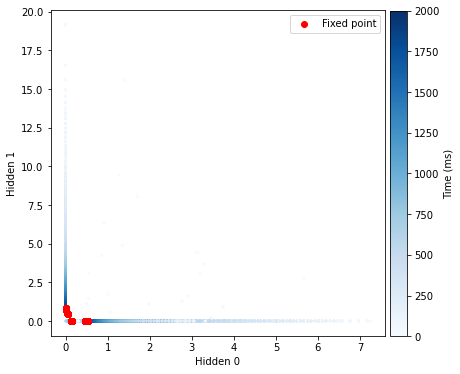

In [19]:
fig = plt.figure(figsize=(6,6))
cmap = cm = plt.get_cmap('Blues') 
for i in range(batch_size):
    sc = plt.scatter(hidden_states[i,:,0],
                     hidden_states[i,:,1],
                     s=2, vmin=0, vmax=maxT*10, cmap=cmap,
                     c=np.linspace(0, maxT*10, hidden_states.shape[1]))
    
plt.scatter(hidden_states[:,-1,0], hidden_states[:,-1,1], c='r', label='Fixed point')
plt.xlabel("Hidden 0")
plt.ylabel("Hidden 1")
plt.legend()
cb_ax = fig.add_axes([.91,.124,.04,.754])
plt.colorbar(sc, cax=cb_ax).set_label('Time (ms)',rotation=90)
plt.savefig(training_kwargs['figures_path'] + "\\fixedpoints_gridinit.pdf")

## Nullclines 

In [20]:
fun = partial(relu_step, W=W_hh, b=b)
results = find_fixed_points(fun, Nrec=Nrec, max_grid=3, step=1, tol = 10**-12,
                            maxiter = 10000, method='Nelder-Mead')

fixed_points = np.unique(results, axis=0)

In [ ]:
#zero inputs
fig = plt.figure(figsize=(6,6))
batch_size = 1
maxT = 2000
for x in fixed_points[:]:
    inputs = torch.zeros((batch_size, maxT, 2), dtype=torch.float)
    hidden = torch.tensor(x, dtype=torch.float) * torch.ones(rnn_model.n_layers, inputs.shape[0], rnn_model.hidden_dim) #random?
    hidden_states, hidden_last = rnn_model.rnn(inputs, hidden)
    hidden_states = hidden_states.detach().numpy()
    plt.scatter(hidden_states[:,-1,0], hidden_states[:,-1,1])
    print(hidden_states[:,-1,:]-x, -x+relu_step(x, W_hh, b))

In [22]:
tol=10**-7
fun = partial(relu_step, W=W_hh, b=b)
results = find_fixed_points(fun, Nrec=Nrec, max_grid=3, step=1, tol = 10**-7,  maxiter = 10000,
                      method='Nelder-Mead')
fixed_points = np.unique(results, axis=0)
fixed_points = np.round(fixed_points, 7)
fixed_points = np.unique(fixed_points, axis=0)
# pos_fixed_points = fixed_points[np.logical_and(fixed_points[:, 0] > 0, fixed_points[:, 1] > 0), :]
nfxdpnts = [len(fixed_points)]
stabilist = find_stabilities(fixed_points, W_hh=W_hh, tol = 10**-4)
stabilist = np.array(stabilist)
fixed_points

#test found fixed points
I=[0,0]
for fxd in fixed_points:
    print(fxd-relu_step_input(fxd, W_hh, b, W_ih, I)) #f(x) = -x + ReLU(Wx+b+I)

[-0.18939261  0.         -0.16344166  0.          0.        ]
[-1.81749961e-01  5.86605000e-02 -2.45404155e-08  0.00000000e+00
  1.78803369e-08]
[-1.05659008e-08  1.36122933e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
[0.         0.01361229 0.         0.         0.        ]
[-1.74013290e-01  7.35770000e-03 -7.36771231e-05  0.00000000e+00
  2.17590048e-08]
[-1.9815398e-08  2.4844885e-09  0.0000000e+00  0.0000000e+00
  0.0000000e+00]
[-3.70687194e-08 -2.08938145e-10  3.05440000e-03  0.00000000e+00
  0.00000000e+00]
[-1.18204169e-08  6.78207661e-02  2.07379028e-08  0.00000000e+00
  0.00000000e+00]
[-2.66305367e-10  8.04326039e-02 -2.52867565e-08  5.00000000e-07
  0.00000000e+00]
[-2.36399617e-08 -1.04317904e-02 -1.61592986e-01  0.00000000e+00
  1.28283000e-02]
[-7.76059718e-03  0.00000000e+00 -5.19095147e-02  0.00000000e+00
 -3.50897938e-08]
[-8.71953593e-09  1.74687000e-02 -4.25226454e-02  0.00000000e+00
  0.00000000e+00]
[ 1.04003667e-05  0.00000000e+00 -4.74814735e-02  0.0000

In [23]:
x = fixed_points[0]
support = np.where(x>tol)[0]
support
fixed_points[0]

array([0., 0., 0., 0., 0.])

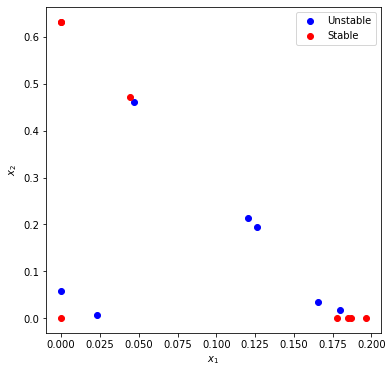

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
colorlist = np.array(['b', 'r'])
labellist = np.array(['Unstable', 'Stable'])
stabilist = np.array(stabilist)
for st in np.unique(stabilist):
    idx = np.where(st==stabilist, True, False)
    sc = plt.scatter(fixed_points[idx,0], fixed_points[idx,1], color=colorlist[st], label=labellist[st])
    
plt.legend()
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.savefig(training_kwargs['figures_path'] + "\\fixedpoints_gridinit_noinput_stabilities.pdf")

In [25]:
#NUMERICAL FXD PNTS
tol=10**-7
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
colorlist = np.array(['b', 'r'])
labellist = np.array(['Unstable', 'Stable'])
cmaps = [plt.get_cmap('Blues') , plt.get_cmap('Reds') ]
eps = .5
Nepspoints = 501 #int(eps*1000+1)
I2s = np.linspace(1-eps, 1.+eps, Nepspoints)
fixed_point_list = []
numberof_fixedpoints = []
for i, I2 in enumerate(I2s):
    I = np.array([1.,I2])
    fun = partial(relu_step_input, W=W_hh, b=b, W_ih=W_ih, I=I)
    results = find_fixed_points(fun, Nrec=Nrec, max_grid=3, step=1, tol = tol,  maxiter = 10000,
                      method='Nelder-Mead')
    fixed_points = np.round(results, 4)
    fixed_points = np.unique(fixed_points, axis=0)
    fixed_point_list.append(fixed_points)
    fixed_points = fixed_points[np.logical_and(fixed_points[:, 0] > -tol, fixed_points[:, 1] > -tol), :]
    nfxdpnts = [len(fixed_points)]
    stabilist = find_stabilities(fixed_points, W_hh=W_hh, tol = 10**-7)
    stabilist = np.array(stabilist)
    scs = [0,0]
    for st in [0,1]:
        idx = np.where(st==stabilist, True, False)
        # sc = plt.scatter(fixed_points[idx,0], fixed_points[idx,1], color=colorlist[st])
        scs[st] = ax.scatter(fixed_points[idx,0], fixed_points[idx,1],
                         vmin=1-eps, vmax=1.+eps,
                         cmap=cmaps[st], c=[1-eps+2*i*eps/Nepspoints]*sum(idx))
        nfxdpnts.append(sum(idx))
    numberof_fixedpoints.append(nfxdpnts)
    
cb_ax = fig.add_axes([.91,.124,.02,.754])
cb_ax2 = fig.add_axes([.93,.124,.02,.754])
fig.colorbar(scs[0], cax=cb_ax, fraction=0.5, pad=0.04).set_ticks([])
fig.colorbar(scs[1], cax=cb_ax2, fraction=0.5, pad=0.04).set_label('$I_2$',rotation=90)
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_xlim([-0.1, 0.8])
# ax.set_title("No input")
plt.savefig(training_kwargs['figures_path'] + "\\fixedpoints_I2inputs_eps%s.pdf"%eps)


KeyboardInterrupt



Error in callback <function flush_figures at 0x00000258882BDE50> (for post_execute):



KeyboardInterrupt



In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

labellist = ['Total', 'Unstable', 'Stable']
colorlist = ['k', 'r', 'b']
for i, nfpnts in enumerate(np.array(numberof_fixedpoints).T):
    plt.plot(I2s, nfpnts, label=labellist[i], color=colorlist[i])
plt.xlabel("$I_2$")
plt.ylabel("Number of fixed points")
plt.legend();
plt.savefig(training_kwargs['figures_path'] + "\\number_of_fixedpoints_noinput_eps%s.pdf"%eps)

In [118]:
r = np.array([0])
W_ih[r,:], I
fixed_points[0]

array([0.04421251, 0.47189133, 0.        , 0.        , 0.        ])

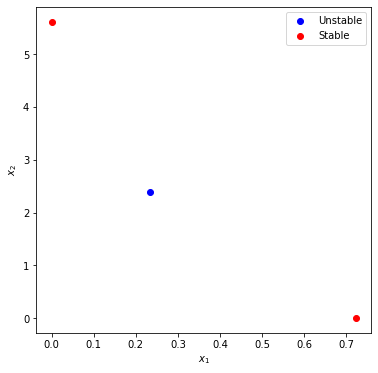

In [141]:
#ANALYTICAL FXD PNTS (no input)
I = [1.2,1.]
fixed_points, stabilist = find_analytic_fixed_points(W_hh, b, W_ih, I)
colorlist = np.array(['b', 'r'])
labellist = np.array(['Unstable', 'Stable'])
stabilist = np.array(stabilist)
fixed_points =  np.array(fixed_points)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# for i,x in enumerate(fixed_points):
#     print(x) #f(x) = -x + ReLU(Wx+b+I)
#     # plt.plot(x[2], x[1], 'x', )

for st in np.unique(stabilist):
    idx = np.where(st==stabilist, True, False)
    sc = plt.scatter(fixed_points[idx,3], fixed_points[idx,1], color=colorlist[st], label=labellist[st])
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend();
# plt.savefig(training_kwargs['figures_path'] + "\\%s.pdf"%eps)

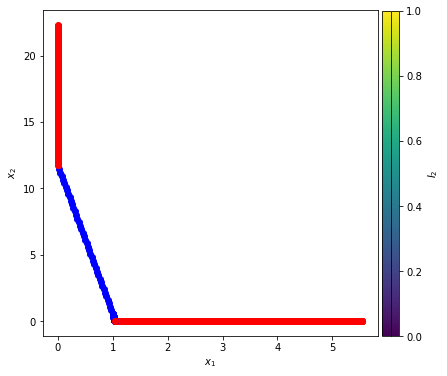

In [176]:
#ANALYTICAL FXD PNTS
tol=10**-4
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
colorlist = np.array(['b', 'r'])
labellist = np.array(['Unstable', 'Stable'])
cmaps = [plt.get_cmap('Blues') , plt.get_cmap('Reds') ]

fixed_point_list = []
numberof_fixedpoints = []
scs = [0,0]

eps = 1.5
Nepspoints = int(eps*1000+1)
I2s = np.linspace(1-eps, 1.+eps, Nepspoints)
I1 = 2.5
for j, I2 in enumerate(I2s):
    I = np.array([I1,I2])
    fixed_points, stabilist = find_analytic_fixed_points(W_hh, b, W_ih, I, tol=tol)
    fixed_points =  np.array(fixed_points)
    numberof_fixedpoints.append([fixed_points.shape[0], np.sum(stabilist), fixed_points.shape[0]-np.sum(stabilist)])

    # for st in [0,1]:
    #     idx = np.where(st==stabilist, 1, 0)
    #     scs[st] = ax.scatter(fixed_points[idx,3], fixed_points[idx,1], s=25)
    for st in np.unique(stabilist):
        idx = np.where(st==stabilist, True, False)
        scs[st] = plt.scatter(fixed_points[idx,3], fixed_points[idx,1], color=colorlist[st], label=labellist[st], cmap=cmaps[st])
    
cb_ax = fig.add_axes([.91,.124,.02,.754])
cb_ax2 = fig.add_axes([.93,.124,.02,.754])
fig.colorbar(scs[0], cax=cb_ax, fraction=0.5, pad=0.04).set_ticks([])
fig.colorbar(scs[1], cax=cb_ax2, fraction=0.5, pad=0.04).set_label('$I_2$',rotation=90)
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
plt.savefig(training_kwargs['figures_path'] + "\\fixedpoints_I2inputs_analytical_eps%s.pdf"%eps)

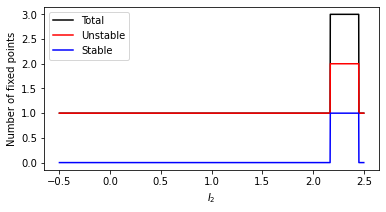

In [177]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

labellist = ['Total', 'Unstable', 'Stable']
colorlist = ['k', 'r', 'b']
for i, nbfxpn in enumerate(np.array(numberof_fixedpoints).T):
    plt.plot(I2s, nbfxpn, color=colorlist[i], label=labellist[i])
plt.xlabel("$I_2$")
plt.ylabel("Number of fixed points")
plt.legend();
plt.savefig(training_kwargs['figures_path'] + "\\number_of_fixedpoints_noinput_analytical_eps%s.pdf"%eps)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
colorlist = np.array(['b', 'r'])
labellist = np.array(['Unstable', 'Stable'])
cmaps = [plt.get_cmap('Blues') , plt.get_cmap('Reds') ]
markerlist = ["o", "v", "*"]
eps = .1
Nepspoints = 101
I2s = np.linspace(1-eps, 1.+eps, Nepspoints)
I1s = [1-eps, 1., 1+eps]
numberof_fixedpoints_I1 = []
fixed_point_list_I1 = []
matplotlib.pyplot.text(-0.05, 0.37, "$I_1$", fontsize=15, horizontalalignment='center', verticalalignment='center')
for j, I1 in enumerate(I1s):
    numberof_fixedpoints = []
    scs = [0,0]
    fixed_point_list = []
    for i, I2 in enumerate(I2s):
        
        I = np.array([I1,I2])
        fun = partial(relu_step_input, W=W_hh, b=b, W_ih=W_ih, I=I)
        results = find_fixed_points(fun, Nrec=Nrec, max_grid=3, step=1, tol = 10**-4,  maxiter = 10000,
                      method='Nelder-Mead')
        fixed_points = np.round(results, 4)
        fixed_points = np.unique(fixed_points, axis=0)
        fixed_point_list.append(fixed_points)
        fixed_points = fixed_points[np.logical_and(fixed_points[:, 0] > -tol, fixed_points[:, 1] > -tol), :]
        nfxdpnts = [len(fixed_points)]
        stabilist = find_stabilities(fixed_points, W_hh=W_hh, tol = 10**-7)
        stabilist = np.array(stabilist)
        for st in [0,1]:
            idx = np.where(st==stabilist, True, False)
            # sc = plt.scatter(fixed_points[idx,0], fixed_points[idx,1], color=colorlist[st])
            scs[st] = ax.scatter(fixed_points[idx,0], fixed_points[idx,1],
                            s=25, marker=markerlist[j],
                             vmin=1-eps, vmax=1.+eps,
                             cmap=cmaps[st], c=[1-eps+2*i*eps/Nepspoints]*sum(idx))
            nfxdpnts.append(sum(idx))
        numberof_fixedpoints.append(nfxdpnts)
    ycoord = np.max([np.max(np.array(fixed_points[:,1])) for fixed_points in fixed_point_list])
    matplotlib.pyplot.text(-0.05, 0.345-j*0.06, str(I1),
    horizontalalignment='center',
     verticalalignment='center')
    fixed_point_list_I1.append(fixed_point_list)
    numberof_fixedpoints_I1.append(numberof_fixedpoints)
    
# plt.legend(labellist)
cb_ax = fig.add_axes([.91,.124,.02,.754])
cb_ax2 = fig.add_axes([.93,.124,.02,.754])
fig.colorbar(scs[0], cax=cb_ax, fraction=0.5, pad=0.04).set_ticks([])
fig.colorbar(scs[1], cax=cb_ax2, fraction=0.5, pad=0.04).set_label('$I_2$',rotation=90)
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_xlim([-0.1, 0.8])
plt.savefig(training_kwargs['figures_path'] + "\\fixedpoints_bothinputs_eps%s.pdf"%eps)

NameError: name 'numberof_fixedpoints_I1' is not defined

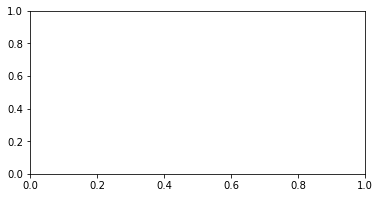

In [147]:
import matplotlib.lines as mlines

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

labellist = ['Total', 'Unstable', 'Stable']
colorlist = ['k', 'r', 'b']
markerlist = ["o", "v", "*"]
lines_I1 = []
for j,numberof_fixedpoints in enumerate(numberof_fixedpoints_I1):
    lines_I2 = []
    for i,nfpnts in enumerate(np.array(numberof_fixedpoints).T):
        lineplot = plt.plot(I2s, nfpnts, label=labellist[i], color=colorlist[i], marker=markerlist[j])
        lines_I2.append(lineplot)
    lines_I1.append(lines_I2)
plt.xlabel("$I_2$")
plt.ylabel("Number of fixed points")

colors_legend_list = []
for i, label in enumerate(labellist):
    line = mlines.Line2D([], [], color=colorlist[i], linewidth=1.5, label=label)
    colors_legend_list.append(line)
    
markers_legend_list = []
for i, label in enumerate(labellist):
    line = mlines.Line2D([], [], color='grey', marker=markerlist[i], linewidth=1.5, label=I1s[i])
    markers_legend_list.append(line)

# line_solid = plt.ploy([], [], color='black', linestyle='-', linewidth=1.5, label=r'$n_\beta = n_o$')
# line_dashed = mlines.Line2D([], [], color='black', linestyle='--', linewidth=1.5, label=r'$n_\beta = n_o/2$')

first_legend = plt.legend(handles=colors_legend_list,bbox_to_anchor=(0.785, 0.50, 0.5, 0.5))
ax = plt.gca().add_artist(first_legend)
second_legend = plt.legend(handles=markers_legend_list,
                           bbox_to_anchor=(0.7, 0.20, 0.5, 0.5)) #best upper-right
second_legend.set_title("$I_1$")

plt.savefig(training_kwargs['figures_path'] + "\\number_of_fixedpoints_inputs_eps%s.pdf"%eps)

# Dynamics

In [91]:
# with open("C:\\Users\\abel_\\Documents\\Rotations\\CIT\\experiments\\lr_clicks.pickle", 'rb') as handle:
#     data_set = pickle.load(handle)

training_kwargs['zero_target'] = 0.
N_test_batch = 10000
pd = PoissonClicks(N_batch=N_test_batch, training_kwargs=training_kwargs)
test_x, y, output_mask, trial_params = pd.get_trial_batch() #generate self.N_batch trials
data_set = [test_x, y, output_mask, trial_params]

inputs = torch.tensor(test_x, dtype=torch.float)
yhat, hidden = rnn_model(inputs)
yhat = yhat.detach().numpy()

x, y, output_mask, trial_params = data_set

In [92]:
#initialize hidden states
inputs = torch.tensor(x, dtype=torch.float)
hidden = torch.zeros(rnn_model.n_layers, inputs.shape[0], rnn_model.hidden_dim) #random?
hidden_states, hidden_last = rnn_model.rnn(inputs, hidden)
hidden_states = hidden_states.detach().numpy()
flat_hidden_states = hidden_states.reshape((-1, hidden_states.shape[-1]))

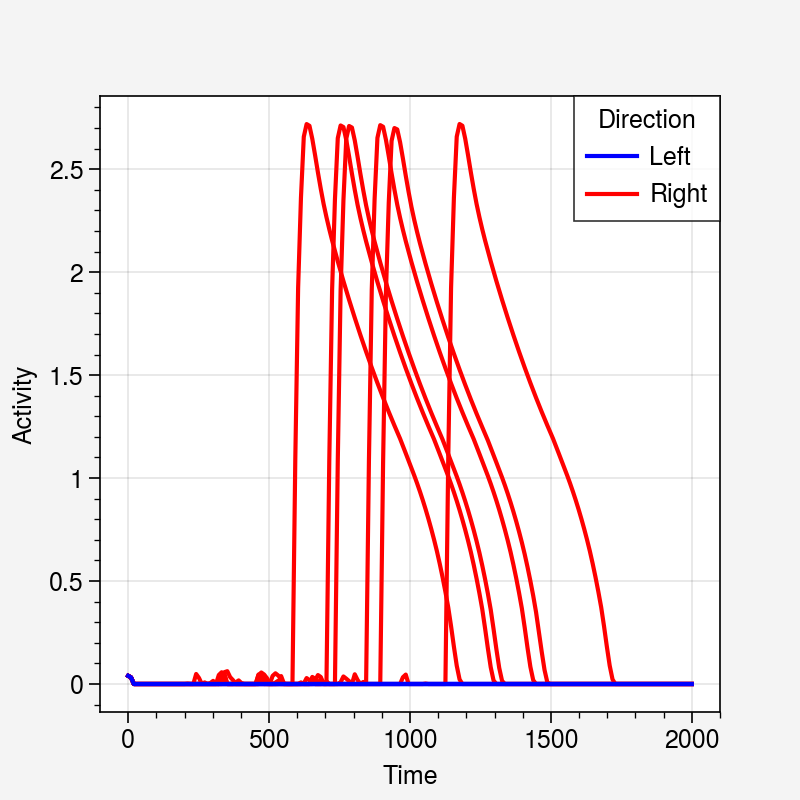

In [93]:
# hidden_states, hidden_last = rnn_model.rnn(inputs, hidden)
# hidden_states = hidden_states.detach().numpy()
directions = np.array([np.where(trial_params[i]['ratio']>1.,1,0) for i in range(trial_params.shape[0])])
colors_list = ['b', 'r']
for trial_i in range(10):
    direction = directions[trial_i]
    plt.plot(np.linspace(0, training_kwargs['T'], hidden_states[trial_i, :, 0].shape[0]), hidden_states[trial_i, :, 0], colors_list[direction])
# plt.ylim([0,1]);
plt.legend(['Left', 'Right'], title='Direction')
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[0].set_color('blue')
leg.legendHandles[1].set_color('red')
plt.xlabel("Time")
plt.ylabel("Activity")
# plt.ylim([0,1])
plt.savefig(training_kwargs['figures_path'] + '\\hidden_activity_10.pdf')

<!-- ###PCA for one coherence data -->
<font size=5>PCA<font>

In [112]:
#PCA for various ratios data
test_kwargs_left = training_kwargs
min_ratio = 1.1
max_ratio = 2
test_kwargs_left['ratios'] = training_kwargs['ratios']
# np.array([np.linspace(min_ratio, max_ratio, 3), np.linspace(-max_ratio, -min_ratio, 3)]).flatten()
data_size = 10000
# pc = PoissonClicks(N_batch=data_size, training_kwargs=test_kwargs_left)
# x, y, output_mask, trial_params = pc.get_trial_batch() 
# data_set = [x, y, output_mask, trial_params]
# with open("C:\\Users\\abel_\\Documents\\Rotations\\CIT\\experiments\\lr_clicks.pickle", 'wb') as handle:
#     pickle.dump(data_set, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open("C:\\Users\\abel_\\Documents\\Rotations\\CIT\\experiments\\lr_clicks.pickle", 'rb') as handle:
#     data_set = pickle.load(handle)
# x, y, output_mask, trial_params = data_set
inputs = torch.tensor(x, dtype=torch.float)
hidden = torch.zeros(rnn_model.n_layers, inputs.shape[0], rnn_model.hidden_dim) #random?
hidden_states, hidden_last = rnn_model.rnn(inputs, hidden)

In [133]:
#initialize hidden states
hidden = torch.zeros(rnn_model.n_layers, inputs.shape[0], rnn_model.hidden_dim) #random?
hidden_states, hidden_last = rnn_model.rnn(inputs, hidden)
hidden_states = hidden_states.detach().numpy()
flat_hidden_states = hidden_states.reshape((-1, hidden_states.shape[-1]))

yhat, _ = rnn_model(inputs)
yhat = yhat.detach().numpy()
hidden_states.shape

(10000, 200, 20)

In [148]:
directions = np.array([trial_params[i]['ratio']<1. for i in range(trial_params.shape[0])])
ratios = np.array([trial_params[i]['ratio'] for i in range(trial_params.shape[0])])

np.where(directions==0)[0]


import pandas


df = pandas.DataFrame.from_records(trial_params)
df = df.round({'ratio': 2})
df['lambdas'] = df['lambdas'].apply(lambda x: np.round(x, 2))
# df['yhat'] = yhat
# df['hidden_states'] = hidden_states

# df['hidden_states'] = df.apply(lambda x: [np.array(x)], axis=1).apply(lambda x: x[0])


In [153]:
df['hidden'] = hidden_states.tolist()
df['yhat'] =  yhat.tolist()
df['inputs'] =  inputs.tolist()

In [154]:
df['hidden']

0       [[0.03971686586737633, 0.14365455508232117, 0....
1       [[0.03971686586737633, 0.14365455508232117, 0....
2       [[0.03971686586737633, 0.14365455508232117, 0....
3       [[0.03971686586737633, 0.14365455508232117, 0....
4       [[0.03971686586737633, 0.14365455508232117, 0....
                              ...                        
9995    [[0.03971686586737633, 0.14365455508232117, 0....
9996    [[0.03971686586737633, 0.14365455508232117, 0....
9997    [[0.03971686586737633, 0.14365455508232117, 0....
9998    [[0.03971686586737633, 0.14365455508232117, 0....
9999    [[0.03971686586737633, 0.14365455508232117, 0....
Name: hidden, Length: 10000, dtype: object

Ratio:  39.0


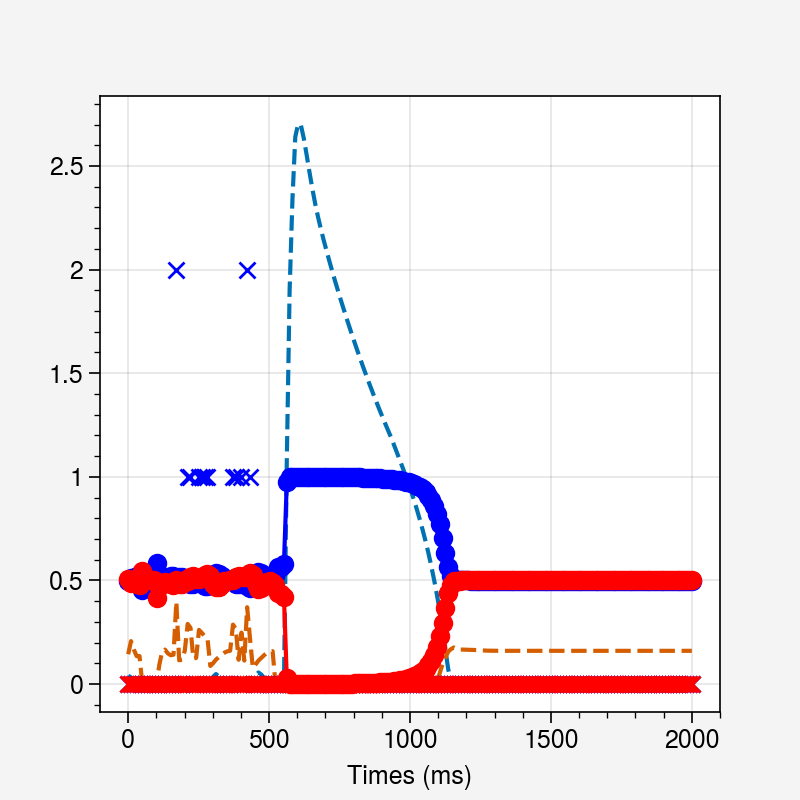

In [97]:
trial_i = 12
print("Ratio: ", trial_params[trial_i]['ratio']) 
times = np.linspace(0, training_kwargs['T'], hidden_states[trial_i, :, 0].shape[0])
if training_kwargs['N_rec']==1:
    plt.plot(times, hidden_states[trial_i, :, 0], '--', label='Hidden')
else:
    plt.plot(times, hidden_states[trial_i, :, 0], '--', label='Hidden 0')
    plt.plot(times, hidden_states[trial_i, :, 1], '--', label='Hidden 1')
plt.plot(times, x[trial_i,:,0], 'xb', label='Input 0')
plt.plot(times, x[trial_i,:,1], 'xr', label='Input 1')

plt.plot(times, yhat[trial_i,:,0], '-ob', label='Output 0')
plt.plot(times, yhat[trial_i,:,1], '-or', label='Output 1')

# plt.plot(times, y[trial_i,:,0], 'ob')
# plt.plot(times, y[trial_i,:,1], 'or')
plt.xlabel("Times (ms)")
# plt.ylim([-7,7])
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)); # Put a legend to the right of the current axis
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=5)
plt.savefig(training_kwargs['figures_path'] + '\\hiddenact_example_ratio%s.pdf'%(trial_params[trial_i]['ratio']))

In [98]:
if training_kwargs['N_rec'] < 11:
    n_components = training_kwargs['N_rec']
else:
    n_components = 10
pca = sklearn.decomposition.PCA(n_components=n_components)
flat_hidden_states = hidden_states.reshape((-1, hidden_states.shape[-1]))
X_new = pca.fit_transform(flat_hidden_states)
X_new.shape

(2000000, 10)

In [99]:
# plt.figure(figsize=(6,6))
# plt.plot(X_new[:,0], X_new[:,1], '.')
# plt.xlabel("PC1")
# plt.ylabel("PC2");
# plt.savefig(training_kwargs['figures_path'] + '\\pca_cohlist_ncomp%s.pdf'%(2))

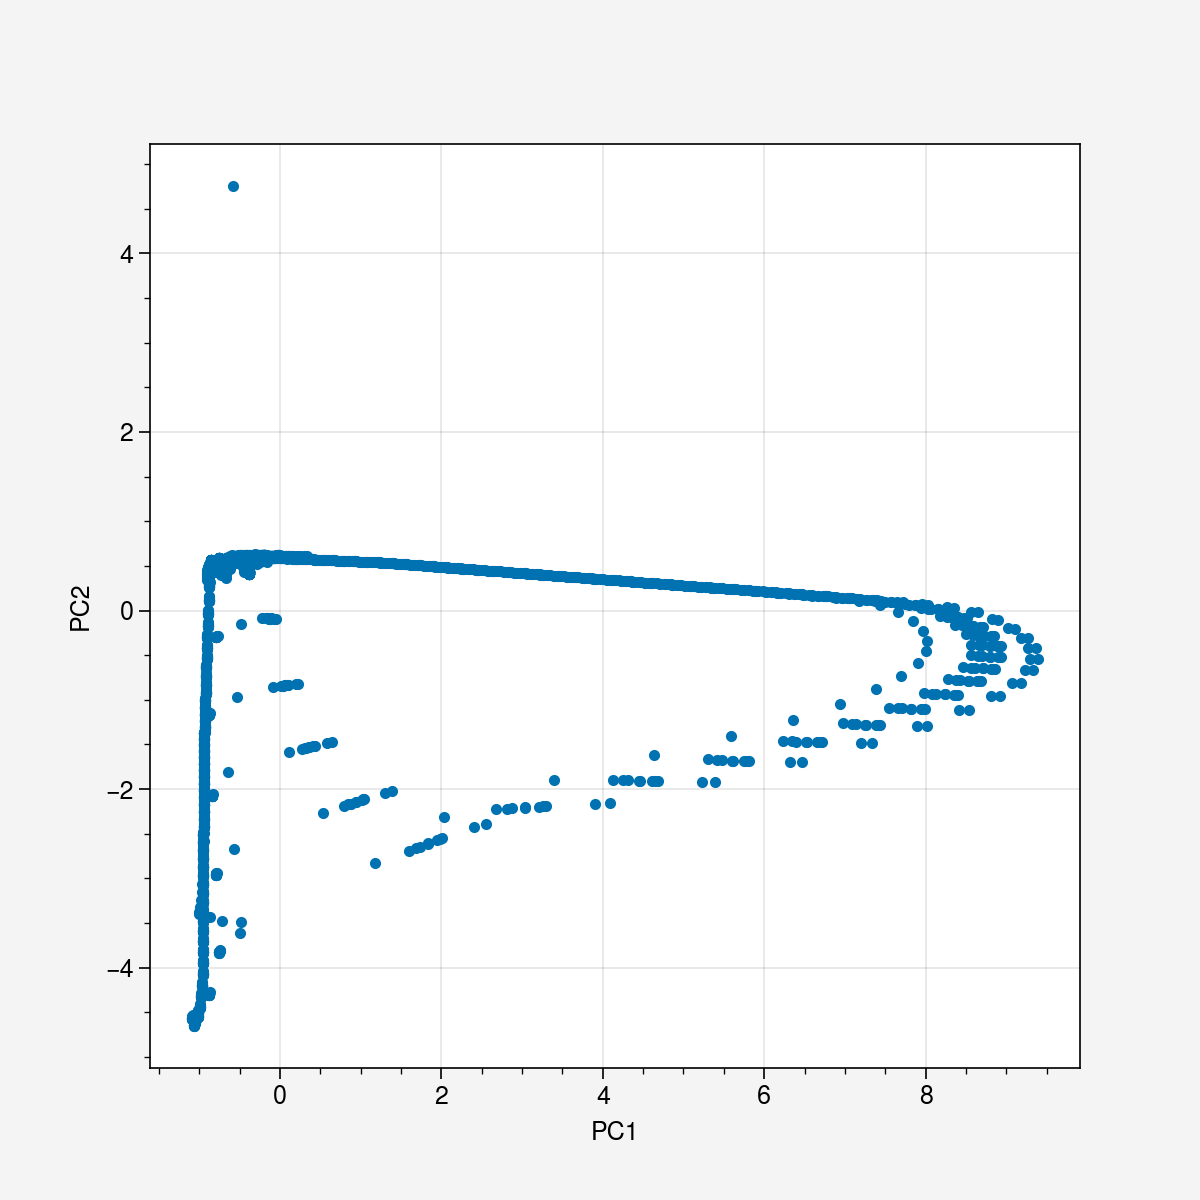

In [100]:
plt.figure(figsize=(6,6))
N_points = 5000
plt.plot(X_new[:N_points,0], X_new[:N_points,1], '.')
plt.xlabel("PC1")
plt.ylabel("PC2");
plt.savefig(training_kwargs['figures_path'] + '\\pca_cohlist_small_ncomp%s.pdf'%(2))

In [101]:
coherence_array = np.array([[trial_params[i]['ratio']]*200 for i in range(len(trial_params))])
flat_coherence_array = coherence_array.reshape(-1)

vmin, vmax = np.min(flat_coherence_array), np.max(flat_coherence_array)
cmap = cm = plt.get_cmap('viridis') 
cNorm  = colors.Normalize(vmin=vmin, vmax=vmax)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)

C:\Users\abel_\AppData\Local\Temp\ipykernel_17572\4277656509.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  m = plt.colorbar(s_m, cax=cb_ax).set_label('Coherence',rotation=90)


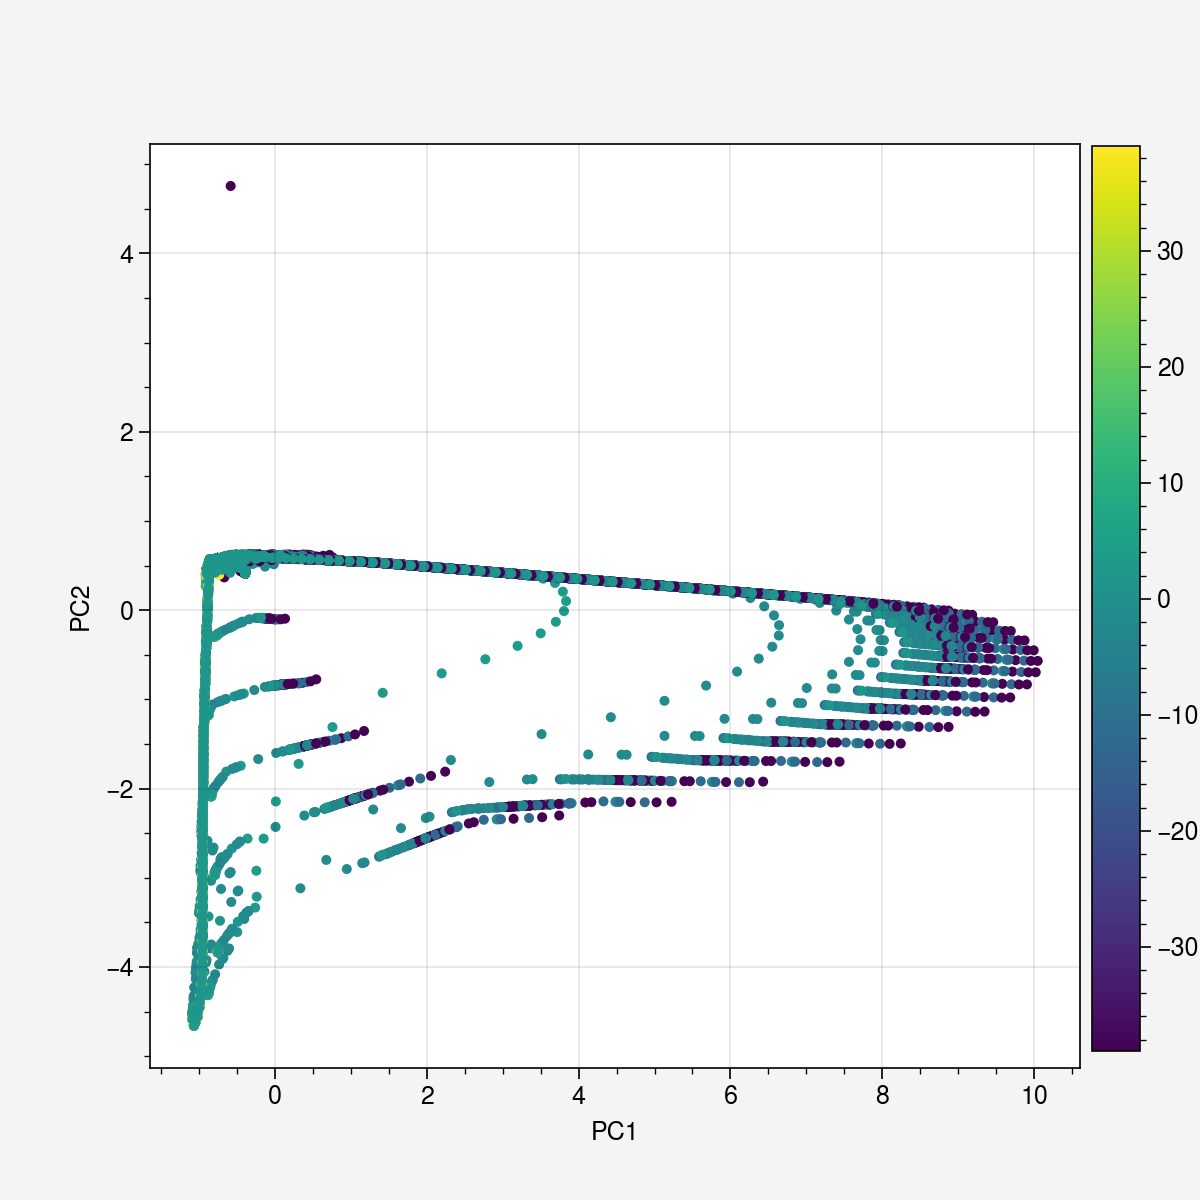

In [102]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# for i in range(X_new.shape[0]):
until = 50000
sc = plt.scatter(X_new[:until,0], X_new[:until,1], marker='.',
                 # levels=coherence_list,
                 vmin=vmin, vmax=vmax, color=scalarMap.to_rgba(flat_coherence_array[:until]))
plt.xlabel("PC1")
plt.ylabel("PC2");
s_m = matplotlib.cm.ScalarMappable(cmap=cmap, norm=cNorm)
cb_ax = fig.add_axes([.91,.124,.04,.754])
s_m.set_clim(vmin, vmax)
m = plt.colorbar(s_m, cax=cb_ax).set_label('Coherence',rotation=90)

plt.savefig(training_kwargs['figures_path'] + '\\pca_cohlist_cohcolor_ncomp_%s.pdf'%(2))

In [103]:
direction_array = np.array([[trial_params[i]['ratio']<1.] for i in range(len(trial_params))])
flat_dir_array = direction_array.reshape(-1)-1

cmap = cm = plt.get_cmap('viridis') 
cNorm  = colors.Normalize(vmin=np.min(flat_dir_array), vmax=np.max(flat_dir_array))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
bounds = [0,.5,1]

C:\Users\abel_\AppData\Local\Temp\ipykernel_17572\2959303973.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = plt.colorbar(s_m, cax=cb_ax, cmap=cmap, norm=cNorm,


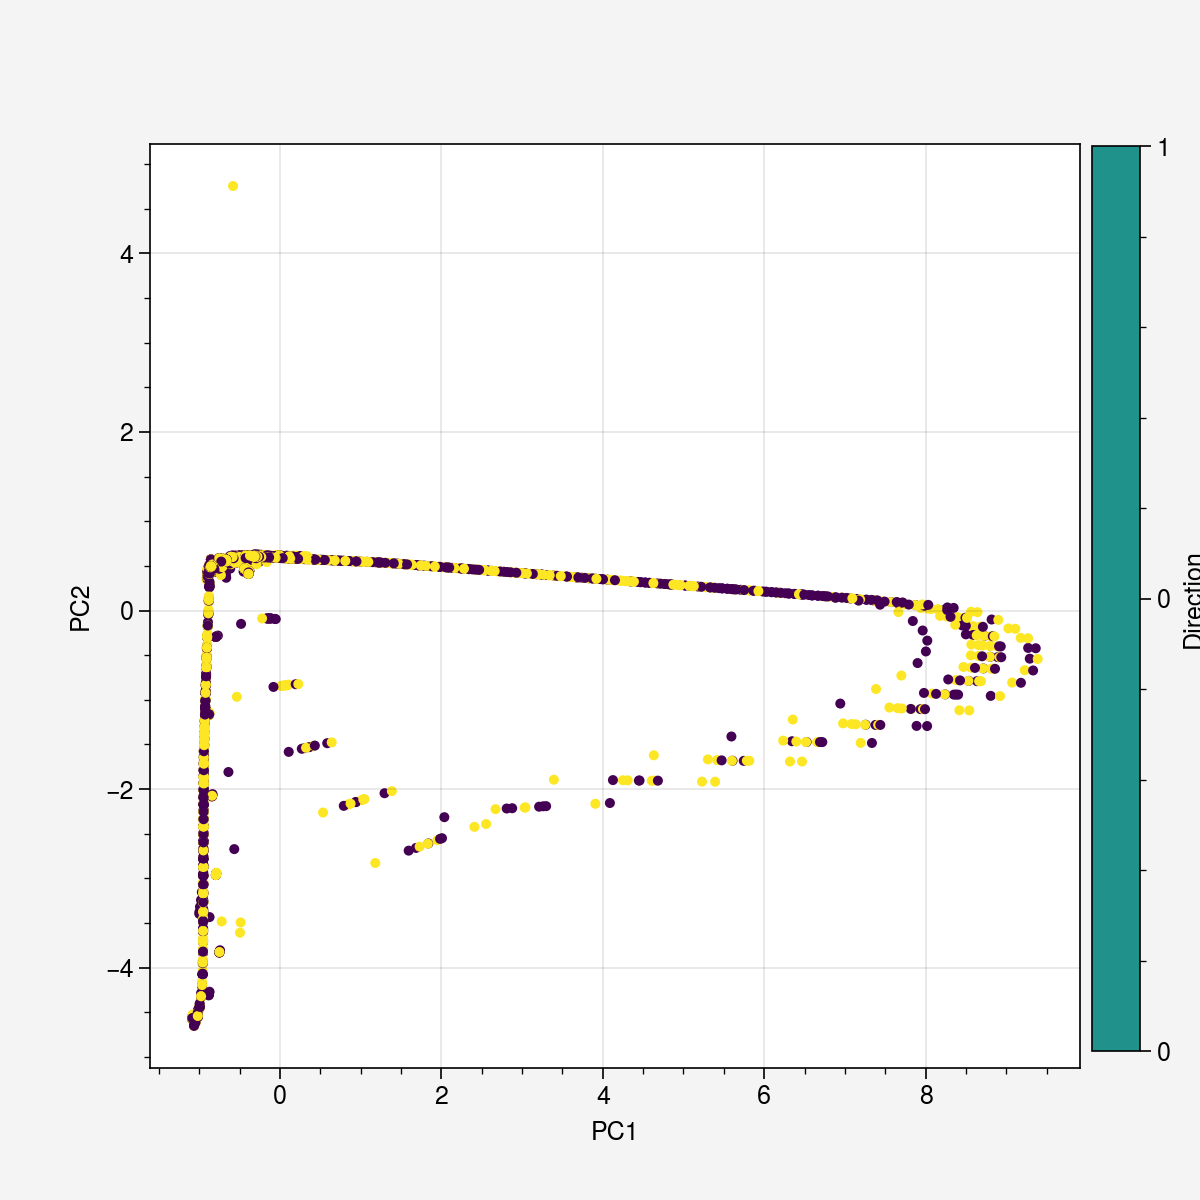

In [104]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# for i in range(X_new.shape[0]):
until = 5000
sc = plt.scatter(X_new[:until,0], X_new[:until,1], marker='.',
                 # levels=coherence_list,
                 vmin=vmin, vmax=vmax, color=scalarMap.to_rgba(flat_dir_array[:until]))
plt.xlabel("PC1")
plt.ylabel("PC2");
s_m = matplotlib.cm.ScalarMappable(cmap=cmap, norm=cNorm)
cb_ax = fig.add_axes([.91,.124,.04,.754])
s_m.set_clim(vmin, vmax)
cb = plt.colorbar(s_m, cax=cb_ax, cmap=cmap, norm=cNorm,
    spacing='proportional', ticks=[0, .5, 1], boundaries=bounds, format='%1i').set_label('Direction',rotation=90)
plt.savefig(training_kwargs['figures_path'] + '\\pca_dircolor_ncomp%s.pdf'%(2))

In [105]:
# y_res = y.reshape((-1,2))
# cmap = cm = plt.get_cmap('viridis') 
# cNorm  = colors.Normalize(vmin=np.min(y), vmax=np.max(y))
# scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
# flat_coherence_array.shape

# plt.figure(figsize=(6,6))
# # for i in range(X_new.shape[0]):
# for i in range(5000):
#     plt.plot(X_new[i,0], X_new[i,1], '.', color=scalarMap.to_rgba(y_res[i,0]))
# plt.xlabel("PC1")
# plt.ylabel("PC2");
# s_m = matplotlib.cm.ScalarMappable(cmap=cmap, norm=cNorm)
# # plt.colorbar(s_m)
# plt.title("Direction")
# plt.savefig(training_kwargs['figures_path'] + '\\pca_cohlist_cohcolor_ncomp_%s.pdf'%(2))

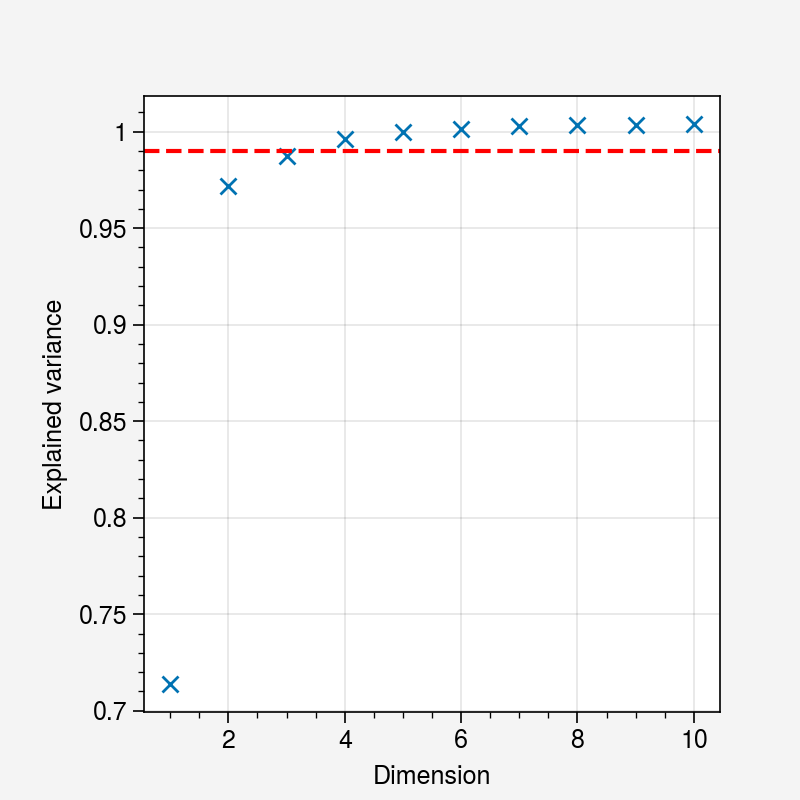

In [106]:
# pca.get_covariance()
plt.plot(range(1, n_components+1), pca.explained_variance_ratio_.cumsum(), 'x')
plt.axhline(y=0.99, color = 'r', linestyle = '--')
# plt.axhline(y=0.999, color = 'r', linestyle = '--')
plt.xlabel("Dimension")
plt.ylabel("Explained variance");
plt.gcf().subplots_adjust(left=0.18)

plt.savefig(training_kwargs['figures_path'] + '\\varexpl_cohlist.pdf')

Loading

C:\Users\abel_\AppData\Local\Temp\ipykernel_17572\3298740863.py:7: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


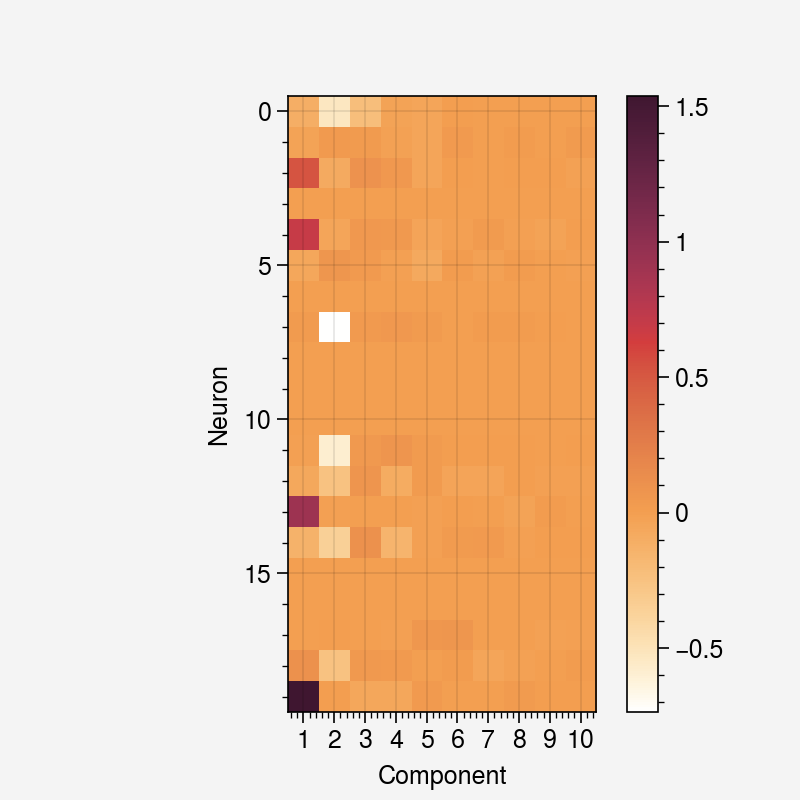

In [107]:
loading_matrix = pca.components_.T * np.sqrt(pca.explained_variance_)
plt.imshow(loading_matrix)
plt.xticks(range(0,n_components),range(1,n_components+1))
plt.yticks(range(0,training_kwargs['N_rec'], 5))
plt.xlabel("Component")
plt.ylabel("Neuron")
plt.colorbar()
plt.savefig(training_kwargs['figures_path'] + '\\loadingmat_cohlist.pdf')

In [108]:
# most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_components)]

# initial_feature_names = [i for i in range(training_kwargs['N_rec'])]
# most_important_names = [initial_feature_names[most_important[i]] for i in range(n_components)]
# dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_components)}
# df = pd.DataFrame(dic.items())

# print("Most important neurons")
# df

In [109]:
def plot_cohdir_trajectories_2(trajectories, unstable_fixedpoint, trial_params, 
                               coherence_list, N_trial_plot=0, point_size = 2, label_text="Neuron",
                               cmaps=[plt.get_cmap('blues') , plt.get_cmap('reds')],
                               save_name='trajectories_fixedduronset_cohdir_condmean'):
    """
    Args: 
    N_trial_plot: to add N_trial_plot random trajectories
    
    """
    flat_trajectories = trajectories.reshape((-1, trajectories.shape[-1]))
    x_min, x_max = np.min(flat_trajectories[:,0]), np.max(flat_trajectories[:,0])
    y_min, y_max = np.min(flat_trajectories[:,1]), np.max(flat_trajectories[:,1])
    x_padding = (x_max-x_min)/10
    y_padding = (y_max-y_min)/10
    
    directions = np.array([np.where(trial_params[i]['ratio']>1.,1,0) for i in range(trial_params.shape[0])])
    ratios = np.array([np.abs(trial_params[i]['ratio']) for i in range(trial_params.shape[0])])
    
    fig, axes = plt.subplots(2, len(coherence_list), figsize=(10, 5), sharey=True, sharex=True)
    cmap1, cmap2 = cmaps 

    trials_per_cohanddir = [[[], []]]*len(coherence_list) #list of lists: per coherence, then perdirection
    for coh_i,coherence in enumerate(coherence_list):
        for direction in [0,1]:
            ax_idx = coh_i*2 + direction
            arr1 = np.where(ratios==coherence)[0]
            arr2 = np.where(directions==direction)[0]
            intersection = [idx for idx in arr1 if idx in arr2]
            for trial_i in intersection:
                    trials_per_cohanddir[coh_i][direction].append(trajectories[trial_i,:,:])
            # trials_per_cohanddir[coh_i][direction] = trajectories[intersection,:,:]

            # cond_mean = np.mean(trials_per_cohanddir[coh_i][direction], axis=0)
            cond_mean = np.mean(np.array(trials_per_cohanddir[coh_i][direction]), axis=0)
            sc = axes[direction, coh_i].scatter(cond_mean[:,0], cond_mean[:,1], s=1, marker='o',
                                           vmin=0, vmax=training_kwargs['T'], cmap=cmap2,
                                          c=np.linspace(0, training_kwargs['T'], hidden_states.shape[1]), zorder=3)

            if N_trial_plot>0:
                random_trials = np.random.choice(intersection, N_trial_plot)
                for trial_i in random_trials:
                    axes[direction, coh_i].plot(trajectories[trial_i,:,:][:,0], trajectories[trial_i,:,:][:,1],
                                                '-', color='0.8', linewidth=.5, zorder=1)
                    sc2 = axes[direction, coh_i].scatter(trajectories[trial_i,:,:][:,0],
                                     trajectories[trial_i,:,:][:,1],
                                     s=point_size, vmin=0, vmax=training_kwargs['T'], cmap=cmap1,
                                     c=np.linspace(0, training_kwargs['T'], trajectories.shape[1]), zorder=2)

            if np.all(unstable_fixedpoint) != None:
                axes[direction, coh_i].scatter(unstable_fixedpoint[0], unstable_fixedpoint[1], s=50, c='m', marker='x', zorder=2)
            if direction == 0:
                axes[direction, coh_i].set_title("%s"%coherence)

            axes[direction, coh_i].set_xlim([x_min-x_padding, x_max+x_padding])
            axes[direction, coh_i].set_ylim([y_min-y_padding, y_max+y_padding])
            axes[direction, coh_i].set_xlabel(label_text + " 1")
            if direction==0:
                axes[direction, coh_i].set_ylabel("Right \n \n "+label_text+" 2")
            else:
                axes[direction, coh_i].set_ylabel("Left \n \n "+label_text+" 2")

    cb_ax = fig.add_axes([.91,.124,.02,.754])
    cb_ax2 = fig.add_axes([.93,.124,.02,.754])
    fig.colorbar(sc, cax=cb_ax, fraction=0.5, pad=0.04).set_ticks([])
    fig.colorbar(sc2, cax=cb_ax2, fraction=0.5, pad=0.04).set_label('Time (ms)',rotation=90)
    fig.supylabel('Direction')
    fig.suptitle("    Coherence")
    for ax in plt.gcf().axes:
        try:
            ax.label_outer()
        except:
            pass
    
    if N_trial_plot>0:
        plt.savefig(training_kwargs['figures_path'] + '\\'+save_name+'_examples.pdf', bbox_inches="tight")
    else:
        plt.savefig(training_kwargs['figures_path'] + '\\'+save_name+'.pdf', bbox_inches="tight")

In [110]:
def plot_clicks_trajectories_2(x, yhat, output_mask, extra_trial_params,
                                trajectories, unstable_fixedpoint, trial_params, 
                                coherence_list, N_trial_plot=0, point_size = 2, label_text="Neuron",
                                cmaps=[plt.get_cmap('blues') , plt.get_cmap('reds')],
                                save_name='trajectories_fixedduronset_cohdir_condmean'):
    """
    Args: 
    N_trial_plot: to add N_trial_plot random trajectories
    
    """
    flat_trajectories = trajectories.reshape((-1, trajectories.shape[-1]))
    x_min, x_max = np.min(flat_trajectories[:,0]), np.max(flat_trajectories[:,0])
    y_min, y_max = np.min(flat_trajectories[:,1]), np.max(flat_trajectories[:,1])
    x_padding = (x_max-x_min)/10
    y_padding = (y_max-y_min)/10
    
    # ratios = np.array([np.abs(trial_params[i]['ratio']) for i in range(trial_params.shape[0])])
    accuracy, response_correctness, choice_proportion_per_ratio, average_accuracy_per_ratio, N_clicks, highest_click_count_index, excludeequals = get_accuracy_poissonclicks_w(x, yhat, output_mask, extra_trial_params)
    click_diffs = N_clicks[:,0]-N_clicks[:,1]
    directions = np.array([np.where(click_diffs>0,1,0) for i in range(trial_params.shape[0])])
    
    fig, axes = plt.subplots(2, len(coherence_list), figsize=(10, 5), sharey=True, sharex=True)
    cmap1, cmap2 = cmaps 

    trials_per_cohanddir = [[[], []]]*len(coherence_list) #list of lists: per coherence, then perdirection
    trials_per_cohanddir = [[[], []]]*len(clicks_list) #list of lists: per coherence, then perdirection
    for coh_i, coherence in enumerate(click_diffs):
        for direction in [0,1]:
            ax_idx = coh_i*2 + direction
            arr1 = np.where(click_diffs==coherence)[0]
            arr2 = np.where(directions==direction)[0]
            intersection = [idx for idx in arr1 if idx in arr2]
            for trial_i in intersection:
                    trials_per_cohanddir[coh_i][direction].append(trajectories[trial_i,:,:])
            # trials_per_cohanddir[coh_i][direction] = trajectories[intersection,:,:]

            # cond_mean = np.mean(trials_per_cohanddir[coh_i][direction], axis=0)
            cond_mean = np.mean(np.array(trials_per_cohanddir[coh_i][direction]), axis=0)
            sc = axes[direction, coh_i].scatter(cond_mean[:,0], cond_mean[:,1], s=1, marker='o',
                                           vmin=0, vmax=training_kwargs['T'], cmap=cmap2,
                                          c=np.linspace(0, training_kwargs['T'], hidden_states.shape[1]), zorder=3)

            if N_trial_plot>0:
                random_trials = np.random.choice(intersection, N_trial_plot)
                for trial_i in random_trials:
                    axes[direction, coh_i].plot(trajectories[trial_i,:,:][:,0], trajectories[trial_i,:,:][:,1],
                                                '-', color='0.8', linewidth=.5, zorder=1)
                    sc2 = axes[direction, coh_i].scatter(trajectories[trial_i,:,:][:,0],
                                     trajectories[trial_i,:,:][:,1],
                                     s=point_size, vmin=0, vmax=training_kwargs['T'], cmap=cmap1,
                                     c=np.linspace(0, training_kwargs['T'], trajectories.shape[1]), zorder=2)

            if np.all(unstable_fixedpoint) != None:
                axes[direction, coh_i].scatter(unstable_fixedpoint[0], unstable_fixedpoint[1], s=50, c='m', marker='x', zorder=2)
            if direction == 0:
                axes[direction, coh_i].set_title("%s"%coherence)

            axes[direction, coh_i].set_xlim([x_min-x_padding, x_max+x_padding])
            axes[direction, coh_i].set_ylim([y_min-y_padding, y_max+y_padding])
            axes[direction, coh_i].set_xlabel(label_text + " 1")
            if direction==0:
                axes[direction, coh_i].set_ylabel("Right \n \n "+label_text+" 2")
            else:
                axes[direction, coh_i].set_ylabel("Left \n \n "+label_text+" 2")

    cb_ax = fig.add_axes([.91,.124,.02,.754])
    cb_ax2 = fig.add_axes([.93,.124,.02,.754])
    fig.colorbar(sc, cax=cb_ax, fraction=0.5, pad=0.04).set_ticks([])
    fig.colorbar(sc2, cax=cb_ax2, fraction=0.5, pad=0.04).set_label('Time (ms)',rotation=90)
    fig.supylabel('Direction')
    fig.suptitle("    Coherence")
    for ax in plt.gcf().axes:
        try:
            ax.label_outer()
        except:
            pass
    
    if N_trial_plot>0:
        plt.savefig(training_kwargs['figures_path'] + '\\'+save_name+'_examples.pdf', bbox_inches="tight")
    else:
        plt.savefig(training_kwargs['figures_path'] + '\\'+save_name+'.pdf', bbox_inches="tight")

In [111]:
flat_hidden_states = hidden_states.reshape((-1, hidden_states.shape[-1]))
X_new = pca.fit_transform(flat_hidden_states)
trajectories = np.zeros((hidden_states.shape[0], 200, training_kwargs['N_rec']))

for trial_i in range(hidden_states.shape[0]):
    trajectories[trial_i, :,:] = pca.transform(hidden_states[trial_i,:,:])
    
coherence_list = np.array(training_kwargs['ratios'])[np.array(training_kwargs['ratios']) > 0] #np.linspace(min_ratio, max_ratio, 3)

plot_cohdir_trajectories_2(trajectories, None, trial_params, coherence_list, N_trial_plot=1,
                            label_text="PC", save_name='trajectories_cohdir_condmean_pc2')

ValueError: could not broadcast input array from shape (200,10) into shape (200,20)

In [ ]:
# trajectories = hidden_states
# plot_cohdir_trajectories_2(trajectories, None, trial_params, coherence_list, N_trial_plot=5,
#                             label_text="Neuron", cmaps=[plt.get_cmap('blues'), plt.get_cmap('reds')], save_name='trajectories_cohdir_condmean')

In [40]:
#same as above but with fixed stimulus durations (random from list)

#solution 2: create test set with discrete durations
training_kwargs['stim_durations'] = list(np.linspace(150, 750, 7))
training_kwargs['stim_durations'] = [500]
training_kwargs['onset_times'] = [200]

test_kwargs = training_kwargs 
test_kwargs['coherence_list'] = coherence_list
test_kwargs['coherence'] = None
N_test_batch = 5000
pd = PoissonClicks(N_batch=N_test_batch, training_kwargs=test_kwargs)
test_x, test_y, test_output_mask, test_trial_params = pd.get_trial_batch() #generate self.N_batch trials
test_set = [test_x, test_y, test_output_mask, test_trial_params]

# with open("C:\\Users\\abel_\\Documents\\Rotations\\CIT\\experiments\\test_set_pca_stimdur.pickle", 'wb') as handle:
#     pickle.dump(test_set, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# with open("C:\\Users\\abel_\\Documents\\Rotations\\CIT\\experiments\\test_set_pca_stimdur.pickle", 'rb') as handle:
#     test_set = pickle.load(handle)
    
x, y, output_mask, trial_params = test_set

In [41]:
#initialize hidden states
inputs = torch.tensor(x, dtype=torch.float)
hidden = torch.zeros(rnn_model.n_layers, inputs.shape[0], rnn_model.hidden_dim) #random?
hidden_states, hidden_last = rnn_model.rnn(inputs, hidden)
hidden_states = hidden_states.detach().numpy()
flat_hidden_states = hidden_states.reshape((-1, hidden_states.shape[-1]))

In [42]:
for unit_i in range(Nrec):
    plt.plot(range(0, 2000, 10), x[:5000,..., unit_i].T, 'b')
    plt.plot(range(0, 2000, 10), hidden_states[:5000,..., unit_i].T, 'r');
    plt.plot([0,inputs.shape[1]*10], [unstable_fixedpoint[unit_i], unstable_fixedpoint[unit_i]], 'g--')
    plt.xlabel("Time (ms)")
    plt.ylabel("Activity")
    plt.legend(["Input", "Hidden state", "Unstable fixed point"])
    ax = plt.gca()
    leg = ax.get_legend()
    leg.legendHandles[0].set_color('b')
    leg.legendHandles[1].set_color('r')
    leg.legendHandles[2].set_color('g')
    plt.savefig(training_kwargs['figures_path'] + '\\trajectories_unstable_fixedpoint_unit%s.pdf'%unit_i, bbox_inches="tight")

NameError: name 'Nrec' is not defined

In [43]:
trajectories = hidden_states
plot_cohdir_trajectories_2(trajectories, unstable_fixedpoint, trial_params, coherence_list, N_trial_plot=5, point_size = 2,
                            label_text="Neuron", cmaps=[plt.get_cmap('Blues'), plt.get_cmap('Reds')], save_name='trajectories_fixedduronset_cohdir_condmean')

NameError: name 'unstable_fixedpoint' is not defined